# Training a simple emulator for LSST-Y1 cosmic shear
This notebook is intended to demostrate the process of training, testing, and using our emulator. We generated cosmic shear data vectors with only $A_s \times 10^{9}$ and $\Omega_{\rm m}$ as our running parameters. We generated the training data using a fisher forcast on the full 3x2pt data vectors and neglecting unused parameters (only lens photo-$z$ parameters) and tempered the fisher matrix by a temperature $T=$ **DETERMINE WHAT TEMPERATURE WORKS.** 


The fiducial values are:
 - $\Omega_m = 0.3$
 - $A_s \times 10^{9} = 2.1$
 
The remaining parameters are fixed at:
 - $n_s = 0.97$
 - $\Omega_{\rm b} = 0.048$
 - $H_0 = 69.0 \,$ km s$^{-1}$ Mpc$^{-1}$
 - $\Delta z_{\rm S, LSST}^i = 0$
 - $IA_{1,1} = 0.5$
 - $IA_{1,2} = 0$

This notebook is only requires numpy and pytorch as external dependencies. 

We will not demonstrate how to generate training data. Training data is completely dependent on the use case of the emulator and the software needed to get the data. For example, while we use cosmolike to generate the cosmic shear data vectors, CMB power spectra only need CAMB.

In [1]:
import numpy as np
import torch
import torch.nn as nn

from projects.lsst_y1.cocoa_emu import cocoa_config                # reads a cobaya yaml file
from projects.lsst_y1.cocoa_emu import nn_pca_emulator             # class for training, saving and load the emulator
from projects.lsst_y1.cocoa_emu.nn_emulator import Affine, \
                                  Better_ResBlock # These are building blocks of the neural network

### Defining the model
Here we need to construct the neural network model that we will train. For demonstration, we will use a ResMLP architecture with 3 hidden blocks of size **what size?**. In addition, we have linear layers that transform the input dimension to the internal dimension and the internal dimension to the data vector dimension, as well as a scaling layer at the end ($\verb|Affine()|$). 

In [2]:
in_dim=2           # input dimension
int_dim_res = 64   # internal dimension
out_dim = 780      # data vector dimension

layers = []
layers.append( nn.Linear(in_dim, int_dim_res)            )
layers.append( Better_ResBlock(int_dim_res, int_dim_res) )
layers.append( Better_ResBlock(int_dim_res, int_dim_res) )
layers.append( Better_ResBlock(int_dim_res, int_dim_res) )
layers.append( nn.Linear(int_dim_res,out_dim)            )
layers.append( Affine()                                  )

model = nn.Sequential(*layers)

### Cocoa_config
This reads a cocoa-style configuration file. It reads the .datafile, primarily to get the fiducial datavector and covariance matrix so that we can preprocess the training data, compute the likelihood/$\chi^2$, and run chains.

In [3]:
configfile = "projects/lsst_y1/demo_emulator.yaml" # cobaya configuration
config = cocoa_config(configfile)

cov_inv = config.cov_inv_masked
dv_fid  = config.dv_masked

datafile read complete
loaded config


### Loading the training and validation data
We store these as .npy binaries

In [4]:
n = 25000 # the number of training points we want to use. Each file has 50k

train_samples      = np.load("./projects/lsst_y1/training_data/demo_t64_samples_0.npy")[:n]
train_data_vectors = np.load("./projects/lsst_y1/training_data/demo_t64_data_vectors_0.npy")[:n,:780]

validation_samples      = np.load("./projects/lsst_y1/training_data/demo_t32_samples_0.npy")[::20]
validation_data_vectors = np.load("./projects/lsst_y1/training_data/demo_t32_data_vectors_0.npy")[::20,:780]

### Data preprocessing
The goal here is to simplify the problem that the neural network needs to solve. For cosmic shear, we just diagonalize and rescale the data basis and rescale the parameters. This does two things: moves all input and output data to be $\mathcal{O}(1)$ and removes covariance in the prediction entries. If one does a fisher forcast on the relevant cosmological parameters, we can use the inverse to also diagonalize the input parameters.

In [5]:
# get the mean and standard deviation of the training data
parameters_mean = np.mean(train_samples,axis=0)
parameters_stdev = np.std(train_samples,axis=0)

# shift and rescale the parameters
train_samples      = (train_samples      - parameters_mean) / parameters_stdev
validation_samples = (validation_samples - parameters_mean) / parameters_stdev

# diagonalize the data covariance and
eigensys = np.linalg.eigh(config.cov[:780,:780])
evals = eigensys[0]
evecs = eigensys[1]

# rotate to the diagonal basis
train_data_vectors = np.transpose((np.linalg.inv(evecs) @ np.transpose(train_data_vectors - dv_fid)))
validation_data_vectors = np.transpose((np.linalg.inv(evecs) @ np.transpose(validation_data_vectors - dv_fid)))

# compute the diagonalized cov
cov_inv_diag = np.diag(1/evals)
dv_stdev = np.sqrt(evals)

In [6]:
##### TRAINING PROCESS #####
print("Number of training points:  ", len(train_samples))
print("Number of validation points:", len(validation_samples))

device = torch.device('cpu')

# convert data to torch tensors
TS = torch.as_tensor(train_samples,dtype=torch.float)
TDV = torch.as_tensor(train_data_vectors,dtype=torch.float)
VS = torch.as_tensor(validation_samples,dtype=torch.float)
VDV = torch.as_tensor(validation_data_vectors,dtype=torch.float)

# initalize the emulator
emu = nn_pca_emulator(model,
                        parameters_mean, parameters_stdev,
                        dv_fid, dv_stdev, cov_inv_diag,
                        evecs, device, reduce_lr=True,lr=1e-4,weight_decay=0)

emu.train(TS, TDV, VS, VDV, batch_size=32,n_epochs=20)
emu.save('./projects/lsst_y1/emulator_output/models/demo_model')

Number of training points:   25000
Number of validation points: 2500
Begin training...
epoch 0, loss=2.62971, validation loss=0.03468, lr=1.00E-04 (epoch time: 4.0)
epoch 1, loss=0.02895, validation loss=0.00722, lr=1.00E-04 (epoch time: 4.0)
epoch 2, loss=0.00978, validation loss=0.00538, lr=1.00E-04 (epoch time: 3.9)
epoch 3, loss=0.00773, validation loss=0.00521, lr=1.00E-04 (epoch time: 3.9)
epoch 4, loss=0.00720, validation loss=0.00513, lr=1.00E-04 (epoch time: 3.9)
epoch 5, loss=0.00658, validation loss=0.00480, lr=1.00E-04 (epoch time: 3.9)
epoch 6, loss=0.00630, validation loss=0.00520, lr=1.00E-04 (epoch time: 3.9)
epoch 7, loss=0.00612, validation loss=0.00544, lr=1.00E-04 (epoch time: 3.9)
epoch 8, loss=0.00629, validation loss=0.00422, lr=1.00E-04 (epoch time: 3.9)
epoch 9, loss=0.00578, validation loss=0.00410, lr=1.00E-04 (epoch time: 3.9)
epoch 10, loss=0.00569, validation loss=0.00420, lr=1.00E-04 (epoch time: 3.9)
epoch 11, loss=0.00538, validation loss=0.00465, lr=1.

# Using the model
Now that we have a trained model, we can load the data using the 'load' function in the $\verb|nn_emulator|$ class as follows.

In [7]:
# first we need to 'recreate' the model
in_dim=2           
int_dim_res = 64   
out_dim = 780     

layers = []
layers.append( nn.Linear(in_dim, int_dim_res)            )
layers.append( Better_ResBlock(int_dim_res, int_dim_res) )
layers.append( Better_ResBlock(int_dim_res, int_dim_res) )
layers.append( Better_ResBlock(int_dim_res, int_dim_res) )
layers.append( nn.Linear(int_dim_res,out_dim)            )
layers.append( Affine()                                  )

model = nn.Sequential(*layers)
# recall this from above

###
device = torch.device('cpu')
emu_cs = nn_pca_emulator(model, 0, 0, 0, 0, 0, 0, device=device)
emu_cs.load('./projects/lsst_y1/emulator_output/models/demo_model',device=device)

## Examining the model
Now that we have a trained model, we can look at how well it performs. The first way is to look at the training and validation loss. The output above is not necessarily illuminating on its own. Thus the losses are saved in a file after training for future examination. We can plot this as below.

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

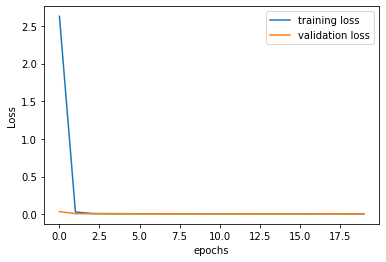

In [9]:
losses = np.loadtxt('losses.txt')
plt.plot(np.transpose(losses[0]), label='training loss')
plt.plot(np.transpose(losses[1]), label='validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

We can see that there is no overfitting during training.

Next we will also want to test the model on another independent dataset. We can load in a dataset and examing its $\chi^2$ distribution over parameter space.

In [10]:
def compute_chi2(params, datavector):
    datavector_emu = emu_cs.predict(torch.Tensor(params))
    diff = (datavector_emu - datavector)
    return diff @ config.cov_inv_masked @ diff

In [11]:
# load a testing dataset
test_samples      = np.load("./projects/lsst_y1/training_data/demo_t16_samples_0.npy")[:]
test_data_vectors = np.load("./projects/lsst_y1/training_data/demo_t16_data_vectors_0.npy")[:,:780]

# compute chi2 for all of these samples
chi2_arr = np.zeros(len(test_samples))
for i,sample in enumerate(test_samples):
    chi2 = compute_chi2(sample,test_data_vectors[i])
    chi2_arr[i] = chi2

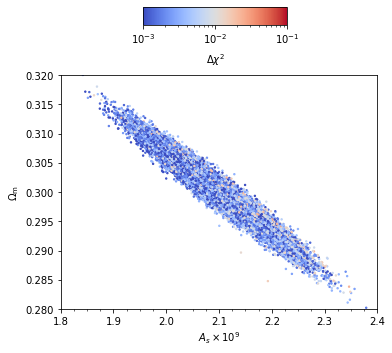

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5),sharex=True,sharey=True)
cmap = plt.cm.get_cmap('coolwarm')
im0 = ax.scatter(test_samples[:,0],test_samples[:,1], 
                   c=chi2_arr, s=2, cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1e-3,vmax=1e-1))

cbar_ax = fig.add_axes([0.3, 0.94, 0.4, 0.05])
fig.colorbar(im0, cax=cbar_ax,orientation='horizontal')
plt.subplots_adjust(left=0.07, bottom=0.15, right=0.95, top=0.8)


ax.set_xlabel(r'$A_s\times 10^9$')
ax.set_ylabel(r'$\Omega_\mathrm{m}$')

ax.set_xlim(1.8,2.4)
ax.set_ylim(0.28,0.32)

cbar_ax.set_xlabel(r'$\Delta\chi^2$',)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
cbar_ax.xaxis.set_label_coords(0.5,-1.5)

# Running an MCMC
After validating the emulator, we are ready to run an MCMC! I will run the MCMC using $\verb|emcee|$ so that we can fix the number of steps performed by each walker. A difference from above is that we no long have an all-ones mask! We want the emulator to learn every piece of the data vector so that we do not need to retrain when choosing different scale cuts. We can pass a different configuration to the cocoa_config class to get the relevent data.

In [13]:
import emcee
import getdist
from getdist import plots
%matplotlib inline

In [29]:
n_walkers = 5
sampling_dim = 2
n_steps = 2000
n_burnin = int(n_steps/2)

params_prior = np.array([[0.5,5.0],  # As_1e9
                        [0.01,0.9]]) # Omega_m

In [23]:
def log_likelihood(theta):
    datavector_emu = emu_cs.predict(torch.Tensor(theta))[config.mask[:780]]
    diff = (datavector_emu - config.dv_masked)
    return -0.5 * diff @ config.cov_inv_masked @ diff

def log_prior(theta):
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
def log_posterior(theta):
    lkl   = log_likelihood(theta)
    prior = log_prior(theta)
    prob  = prior + lkl
    return prob


In [25]:
configfile = "projects/lsst_y1/demo_mcmc.yaml"
config = cocoa_config(configfile)

datafile read complete
loaded config


In [26]:
# create the initial position of the walkers
pos0 = np.array([2.1,0.3]) + np.array([0.1,0.05])*np.random.normal(size=(n_walkers, sampling_dim))

# run the sampler
emu_sampler = emcee.EnsembleSampler(n_walkers, sampling_dim, log_posterior, pool=None)
emu_sampler.run_mcmc(pos0, n_steps, progress=True)
print() # to avoid the mess from printing emu_sampler

100%|███████████████████████████████████████| 2000/2000 [01:37<00:00, 20.59it/s]

Removed no burn in


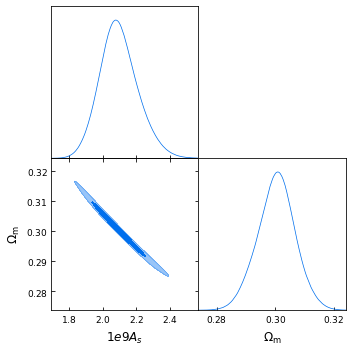

In [30]:
samples = emu_sampler.chain[:,n_burnin::1].reshape((-1,sampling_dim))

gdsamples = getdist.mcsamples.MCSamples(samples=samples,
                              names=['As_1e9','omegam'],
                              labels=['1e9 A_s','\Omega_\mathrm{m}'])

gdplot = plots.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["As_1e9", "omegam"], filled=True)